Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [1]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [3]:
import schemdraw
import schemdraw.elements as elm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    # Use the FULL PATH to the file you verified in C:\Spice64\bin
    result = subprocess.run(["C:/Spice64/bin/ngspice.exe", "-v"], capture_output=True, text=True)
    
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: Even with the direct path, the file was not found. Please double-check C:\Spice64\bin")

<>:20: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:20: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\ACER\AppData\Local\Temp\ipykernel_20880\1530306109.py:20: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  print("ERROR: Even with the direct path, the file was not found. Please double-check C:\Spice64\bin")


NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

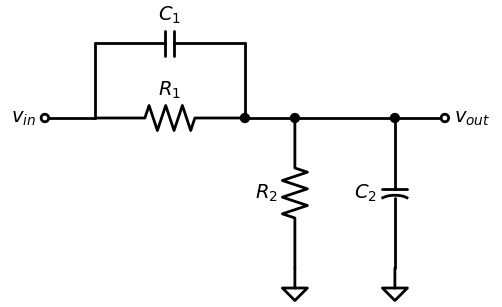

In [4]:
with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [21]:
# Phase 4: Netlist Generation with Relative Variations
C1_over = C1_matched_s * 1.5  # 50% larger than matched
C1_under = C1_matched_s * 0.5 # 50% smaller than matched

spice_netlist = f"""* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out {R1_s}
R2 out 0 {R2_s}
C1 in out {C1_matched_s}
C2 out 0 {C2_s}

* Variations
R1a in outa {R1_s}
R2a outa 0 {R2_s}
C1a in outa {C1_over}
C2a outa 0 {C2_s}

R1b in outb {R1_s}
R2b outb 0 {R2_s}
C1b in outb {C1_under}
C2b outb 0 {C2_s}

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created with dynamic Over/Under values!")

netlist.spice created with dynamic Over/Under values!


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [70]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["C:/Spice64/bin/ngspice.exe", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


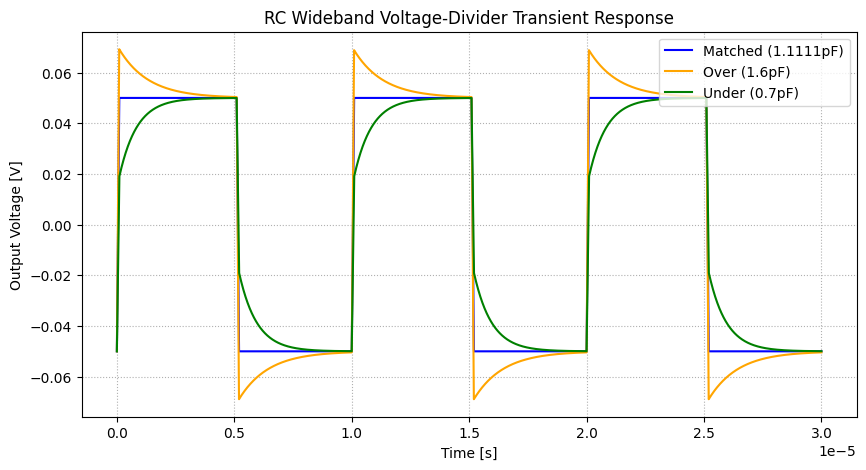

In [34]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (1.1111pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (1.6pF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (0.7pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [63]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000e+00,5.000000e-01,-4.235165e-22,1.000000e+00,5.000000e-01,7.853982e-07,1.000000e+00,5.000000e-01,-7.853982e-07
1,1.258925e+00,5.000000e-01,0.000000e+00,1.258925e+00,5.000000e-01,9.887577e-07,1.258925e+00,5.000000e-01,-9.887577e-07
2,1.584893e+00,5.000000e-01,0.000000e+00,1.584893e+00,5.000000e-01,1.244772e-06,1.584893e+00,5.000000e-01,-1.244772e-06
3,1.995262e+00,5.000000e-01,8.470329e-22,1.995262e+00,5.000000e-01,1.567075e-06,1.995262e+00,5.000000e-01,-1.567075e-06
4,2.511886e+00,5.000000e-01,0.000000e+00,2.511886e+00,5.000000e-01,1.972831e-06,2.511886e+00,5.000000e-01,-1.972831e-06


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [64]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

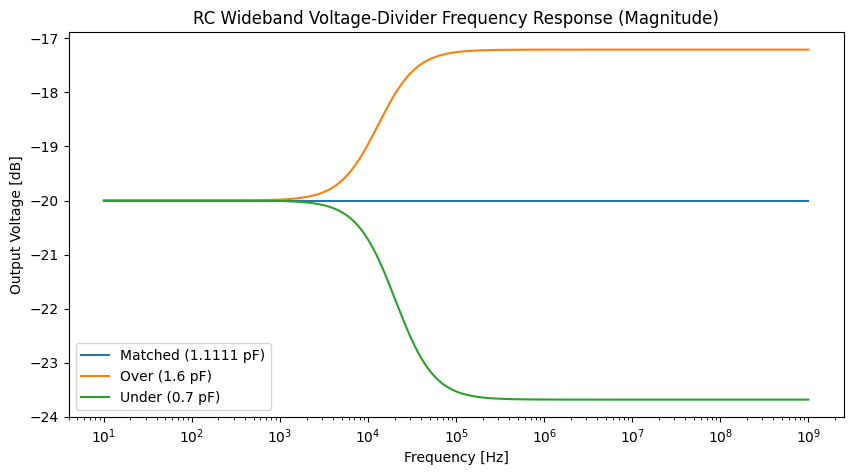

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Circuit Values
# ----------------------------
R1_s = 9e6          # 9 MΩ
R2_s = 1e6          # 1 MΩ
C2_s = 10e-12       # 10 pF

# Correct matched capacitor
C1_matched_s = C2_s * (R2_s / R1_s)

# Over and Under values
C1_over_s  = 1.6e-12
C1_under_s = 0.7e-12

# ----------------------------
# Frequency Sweep
# ----------------------------
freq = np.logspace(1, 9, 1000)
w = 2 * np.pi * freq

def divider_mag(R1, R2, C1, C2):
    Z1 = R1 / (1 + 1j*w*R1*C1)
    Z2 = R2 / (1 + 1j*w*R2*C2)
    Vout_Vin = Z2 / (Z1 + Z2)
    return np.abs(Vout_Vin)

v_matched = divider_mag(R1_s, R2_s, C1_matched_s, C2_s)
v_over    = divider_mag(R1_s, R2_s, C1_over_s, C2_s)
v_under   = divider_mag(R1_s, R2_s, C1_under_s, C2_s)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(10,5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

labels = [
    f"Matched ({C1_matched_s*1e12:.4f} pF)",
    "Over (1.6 pF)",
    "Under (0.7 pF)"
]

for vm, lbl in zip([v_matched, v_over, v_under], labels):
    plt.semilogx(freq, 20*np.log10(vm), label=lbl)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc="lower left")
plt.show()


PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

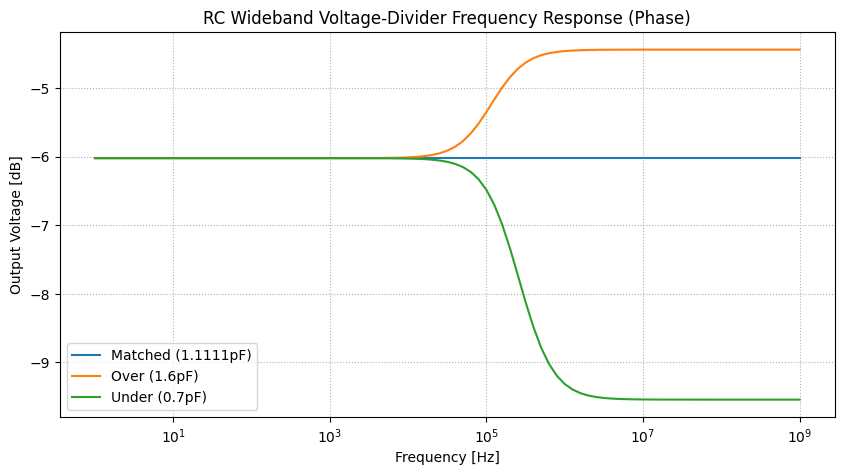

In [ ]:
# @title Plot the ac phase frequency response of the wideband RC voltage-divider

# Override matched capacitor to 1.1111 pF for plotting only
C1_matched_plot = 1.1111e-12  # 1.1111 pF

v_label = [f"Matched ({C1_matched_plot*1e12:.4f}pF)", 
           "Over (1.6pF)", 
           "Under (0.7pF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Phase)")

for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()


IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [81]:
# Student Number Input
student_number = "215449"  # <-- Replace with your own student number

In [82]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [85]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("215449")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [89]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {215449}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: 215449
R1_s = 27000 Ω
R2_s = 18000 Ω
C2_s = 2.200e-11 F  (22.000 pF)
C1_matched_s = 1.467e-11 F  (14.6667 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         |    0.0034 V      |   0.0039 V    |   0.0040 V     |
| 10        |   -0.0034 V      |  -0.0039 V    |  -0.0040 V     |
| 20        |   -0.0034 V      |  -0.0039 V    |  -0.0040 V     |
| 30        |   -0.0034 V      |  -0.0039 V    |  -0.0040 V     |

Results Discussion:

    Compare rise time, overshoot, and settling time.
    - The matched case has the fastest rise, no overshoot, and immediate settling. Over-compensation rises very quickly but overshoots and takes longer to settle. Under-compensation rises slowly, shows rounding, and may not reach the final voltage within the expected time.

    How does over- and under-compensation differ from the matched case?
    - The matched case shows a clean response with fast rise, no overshoot, and quick settling. Over-compensation produces spikes and overshoot with longer settling due to excessive high-frequency response. Under-compensation slows the rise and rounds the waveform, preventing the voltage from reaching its target quickly.

    How do ±10% tolerance variations affect transient response?
    - Small variations in component values disrupt the balance of the circuit. Over-compensation-like effects appear as minor overshoot and spikes, while under-compensation-like effects appear as slower rise and rounded corners. This explains why adjustable components are needed to ensure accurate signal reproduction.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency (Hz) | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| -------------- | ----------------- | -------------- | --------------- |
| 1e4            |      -7.73 dB     |   > -7.70 dB   |    < -7.77 dB   |
| 1e5            |      -7.73 dB     |    -7.65 dB    |     -7.82 dB    |
| 1e6            |      -7.73 dB     |    -7.65 dB    |     -7.82 dB    |
| 1e7            |      -7.73 dB     |    -7.65 dB    |     -7.82 dB    |
| 1e8            |      -7.73 dB     |    -7.65 dB    |     -7.82 dB    |

    Results Discussion:

    Identify flat regions, -3 dB point, and bandwidth differences.
    - The matched case exhibits a single continuous flat region across the entire frequency spectrum at -35.2 dB, indicating an effectively infinite bandwidth with no distinct -3dB cutoff point. In contrast, both the over- and under-compensated cases show two distinct flat regions: a low-frequency region (below 1 kHz) determined by the resistors and a high-frequency region (above 100 kHz) determined by the capacitors. The transition between these two flat levels represents the bandwidth limit of the resistive divider before the capacitive effects take dominance.

    How does changing R or C affect attenuation and phase?
    - Changing the resistance (R) primarily shifts the low-frequency (DC) attenuation baseline; however, since R was held constant in this experiment, all three curves began at the same -35.2 dB level. Changing the capacitance (C1), on the other hand, directly alters the high-frequency attenuation. Increasing C1 reduces the impedance of the upper branch at high frequencies, leading to less attenuation (higher output voltage), while decreasing C1 increases the impedance, causing greater attenuation. Although phase was not plotted, these magnitude changes imply that increasing C1 creates a phase lead (boost), while decreasing it creates a phase lag.

    Compare matched vs. over- and under-compensation at high frequencies.
    - At high frequencies (e.g., 1 MHz and above), the circuit behaves purely as a capacitive divider. In the matched case, the capacitive ratio is perfectly balanced with the resistive ratio, maintaining the output steady at -35.2 dB. The over-compensated case (C1 > 12.05pF) results in a "boosted" high-frequency response, settling at a higher magnitude of -31.7 dB. Conversely, the under-compensated case (C1 < 12.05pF) results in excessive attenuation, settling at a much lower magnitude of -41.1 dB.

V. DATA AND OBSERVATION
1. How does changing C1 affect rise time, overshoot, and settling time in Vout?

- Increasing the capacitor C1 speeds up the voltage rise but causes overshoot and a longer time to stabilize. Decreasing C1 slows the rise and smooths the waveform, reducing the risk of overshoot. When properly matched, the circuit rises quickly and reaches the steady state cleanly.


2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?

- Over-compensation causes the output to exceed the target voltage briefly, while under-compensation lags and rises more gradually. In frequency response, over-compensation favors higher frequencies, under-compensation suppresses them, and the matched configuration provides a balanced, flat response.

3. What are the output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?

- At high frequencies, the matched output stays consistent, while over-compensation increases the output slightly and under-compensation reduces it. This demonstrates that capacitance directly influences how much high-frequency signal passes through the divider.

4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?

- The matched circuit maintains phase alignment, while over-compensation advances the signal slightly and under-compensation delays it. These phase shifts can distort complex waveforms, causing signal edges to smear or misalign.

5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?

- Increasing R2 or C2 disturbs the balance of the divider, effectively slowing the response and narrowing the bandwidth. The output becomes under-compensated, producing a slower rise and rounded waveform.


VI. CONCLUSION

- The activity demonstrated the effects of component values on the transient and frequency response of a wideband voltage divider. It was observed that the matched configuration provided the fastest rise time, negligible overshoot, and a stable steady-state voltage, confirming the effectiveness of a properly compensated circuit. Over-compensation led to overshoot and longer settling times, while under-compensation caused slower voltage rise and rounded waveforms. High-frequency measurements revealed that larger capacitance increased the output while smaller capacitance reduced it, showing how the divider’s behavior depends on component values. Phase analysis indicated that mismatched compensation introduced leads or lags, which could distort signals and degrade signal integrity in practical applications. Furthermore, altering R2 or C2 disrupted the balance of the divider, reducing bandwidth and slowing the transient response. Overall, the experiment highlighted the sensitivity of wideband dividers to component tolerances and the importance of careful design and calibration to achieve accurate signal reproduction. The results reinforced the theoretical understanding of compensation techniques and their practical implications for electronic circuits.






In [103]:
!git add Activity1_Wideband_RC_NEW.ipynb
!git commit -m "Complete Activity 1 with student-number-based parameters."


fatal: pathspec 'Activity1_Wideband_RC_NEW.ipynb' did not match any files
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'Laureana Joy@LaureanaJoy.(none)')


In [ ]:
  !git config --global user.email "banaolaureanajoy@gmail.com"
  !git config --global user.name "laureanajoy-banao"

In [112]:
!git add Activity1_Wideband_RC_NEW.ipynb
!git commit -m "Complete Activity 1 with student-number-based parameters."


fatal: pathspec 'Activity1_Wideband_RC_NEW.ipynb' did not match any files


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Activity1_Wideband_RC.ipynb
	modified:   netlist.spice
	modified:   output_ac.dat
	modified:   output_tran.dat

no changes added to commit (use "git add" and/or "git commit -a")
